In [1]:
%run LongTrail_BuildGraph_ParkingOptional_verySimple.ipynb

In [2]:
from gurobipy import *

# Create a new model
m = Model()

Academic license - for non-commercial use only


In [3]:
gurobiVars = dict()
obj = LinExpr()

#there will be many tours, so creating a bunch of variables for each edge. 
#Each variable can be thought of as "the number of times that we walk this trail during tour # X"
numToursToCreate = 3 #I don't know how many tours there will be, so I'm going to solve this iteratively.
                     # I still want the objective function to be minimum distance, 
                     # So I'll run with a bunch of different values to figure out the minimum numTours that returns an answer
                     # When this was set to 10, the model immediately returned 'infeasable'
        
        
#for each edge, create a variable in the model and add it to the objective function
#if the edge is required, create a separate constraint saying that the edge must be traversed at least once
for u,v,a in G.edges(data=True):
    constForThisEdgeAcrossAllTours = LinExpr()
    for t in range(numToursToCreate):
        for d in range(2):
            thisEdgeName = (str(u) + "_" + str(v) if u < v else str(v) + "_" + str(u)) + "_tour" + str(t) + "_" + str(d) + "_"
            thisVar = m.addVar(vtype=GRB.INTEGER, name=thisEdgeName)
            gurobiVars[thisEdgeName] = thisVar
            obj += (a['weight'] * (thisVar))
            constForThisEdgeAcrossAllTours += thisVar
    if(a['required'] == 1):
        m.addConstr(constForThisEdgeAcrossAllTours >= 1)
    
m.setObjective(obj, GRB.MINIMIZE)

In [4]:
#add a constraint that we can't traverse the same edge in the same direction in the same tour more than once
for t in range(numToursToCreate):
    for u,v,a in G.edges(data=True):
        for d in range(2):
            constForThisEdgeTraverseOnce = LinExpr()
            thisEdgeName = (str(u) + "_" + str(v) if u < v else str(v) + "_" + str(u)) + "_tour" + str(t) + "_" + str(d) + "_"
            constForThisEdgeTraverseOnce += gurobiVars[thisEdgeName]
            m.addConstr(constForThisEdgeTraverseOnce <= 1) 

In [5]:
#add a constraint for total length of each tour

maxLengthPerTour = 18 #miles. Might need to adjust this logic if we eventually want to make the constraint time

for t in range(numToursToCreate):
    constForTotalTourLength = LinExpr()
    for u,v,a in G.edges(data=True):
        for d in range(2):
            thisEdgeName = (str(u) + "_" + str(v) if u < v else str(v) + "_" + str(u)) + "_tour" + str(t) + "_" + str(d) + "_"
            constForTotalTourLength += (a['weight'] * (gurobiVars[thisEdgeName]))
    m.addConstr(constForTotalTourLength <= maxLengthPerTour) 

In [6]:
#add a constraint that says that each tour must connect to a parking location
for t in range(numToursToCreate):
    ParkingConstraintForThisTour = LinExpr()
    for u,v,a in G.edges(data=True):
        if(u == 999 or v == 999):
            for d in range(2):
                edgeName = (str(u) + "_" + str(v) if u < v else str(v) + "_" + str(u)) + "_tour" + str(t) + "_" + str(d) + "_"
                thisEdge = gurobiVars[edgeName]
                ParkingConstraintForThisTour += thisEdge
    m.addConstr(ParkingConstraintForThisTour >= 1)

In [7]:
#now add constraints to ensure that each tour is real. A eulerian tour requires (and will always exist if) no more than two nodes are odd 
#(because the two odd nodes are the start and end node)
#But in this case, let's assume that all nodes are even (the "tour" starts and ends at the same node, "the road")

#In this formulation there are multiple tours and each tour must independently be eurlerian
#so the evenness constraints must hold true for every node in every tour
#eg if a node has cardinality 1 in one tour and 1 in another tour, that doesn't work.

#note that Gurobi doesn't allow modulo operator, so to solve that, declare a dedicated int variable for each
#constraint, and then express each constraint in the form X + Y = 2z (for evenness)
for n in G.nodes():
    for t in range(numToursToCreate):
        WalkingConstraintForThisNode = LinExpr()
        DrivingConstraintForThisNode = LinExpr()
        thisNodeWalkingEvenOddVar = m.addVar(vtype=GRB.INTEGER, name="tour" + str(t) + "WalkingEvennessForNode" + str(n))
        thisNodeDrivingEvenOddVar = m.addVar(vtype=GRB.INTEGER, name="tour" + str(t) + "DrivingEvennessForNode" + str(n))
        for u,v,a in G.edges(n, data=True):
            for d in range(2):
                edgeName = (str(u) + "_" + str(v) if u < v else str(v) + "_" + str(u)) + "_tour" + str(t) + "_" + str(d) + "_"
                thisEdge = gurobiVars[edgeName]
                if(u == 999 or v == 999):
                    DrivingConstraintForThisNode += thisEdge
                else:
                    WalkingConstraintForThisNode += thisEdge
        m.addConstr(WalkingConstraintForThisNode == (2*thisNodeWalkingEvenOddVar))  
        m.addConstr(DrivingConstraintForThisNode == (2*thisNodeDrivingEvenOddVar)) 

In [48]:
#Ok, i'm inventing my own subtour elimination constraint here. It goes like this...
#If we have a subtour, there isn't necessarily anything wrong with the set of edges that we have in the subtour,
#we might just also need to add additional edged to that subtour. This is important for "out and back" or "lollipop" 
#shaped tours. So for these subtours, we look at the set of nodes that are part of the subtour, and then the set of
#edges that are currently included in the subtour. All we know is that the set of edges we currently have is not
#right. So we exclude that specific set of edges. 
#For now, i'm going to assume that the subtour is a good start and say that the number of edges adjacent to those nodes is
#greater than the set that we currently have... but i don't know if that's always true. So I'll test this version out
#and see what it does


#How many subtours are there?
#++If this this tour is already one single tour, we're good
#++If the largest is already connected to a road, expand it

#++Only make one change to one tour at a time. 
#If we go through all tours and there's no tour where we can make this change, end



def subtourelim(model, where):
    global subtourEliminationPhase
    if where == GRB.Callback.MIPSOL:
        print("!!!!!!!!!!!!")
        print("ENTERING CALLBACK FUNCTION")
        print("!!!!!!!!!!!!")
        hasAnythingChanged = 0
        vList_subtourelim = model.getVars()
            
        for t in range(numToursToCreate):
            print("tour" + str(t))
            #I'm using NetworkX to examine the graph and identify sub-tours for each tour
            FinalGraph=nx.Graph()
            #print("TOUR " , str(t))
            for v in vList_subtourelim:
                if(v.varName.find("Evenness") == -1):
                    if(v.varName.find("_tour" + str(t) + "_") != -1):
                        if(int(model.cbGetSolution(v)) > 0.5):
                            edgeNodes = v.varName.split('_')
                            FinalGraph.add_edge(edgeNodes[0],edgeNodes[1])
                            
            plt.figure(1)
            nx.draw(FinalGraph,with_labels=True, font_weight='bold')
            plt.show()

                            
            sub_graphs = sorted(nx.connected_component_subgraphs(FinalGraph), key = len, reverse=True)

            numSubGraphs = nx.number_connected_components(FinalGraph)
            print("subgraphs: " + str(numSubGraphs))
            if(numSubGraphs == 1):
                print("this tour is already connected. moving to the next one")
                continue
            
            minNodeBiggestSubtour = -1
            maxNodeBiggestSubtour = -1
            
            for i, sg in enumerate(sub_graphs):
                print("examining this subgraph:")
                print(sg.edges())
                if(i == 0 and sg.has_node('999') != True):
                    print("the largest subtour is not connected to the road! Adding constraint!")
                    ConstraintForThisSubTour = LinExpr()
                    
                    #get the length of this subgraph
                    thisSgLength = 0
                    for i, sge in enumerate(sg.edges()):
                        edgeNameDir0 = (str(sge[0]) + "_" + str(sge[1]) if int(sge[0]) < int(sge[1]) else str(sge[1]) + "_" + str(sge[0])) + "_tour" + str(t) + "_0_"
                        edgeNameDir1 = (str(sge[0]) + "_" + str(sge[1]) if int(sge[0]) < int(sge[1]) else str(sge[1]) + "_" + str(sge[0])) + "_tour" + str(t) + "_1_"
                        thisSgLength += int(model.cbGetSolution(gurobiVars[edgeNameDir0]))
                        thisSgLength += int(model.cbGetSolution(gurobiVars[edgeNameDir1]))
                    
                    #Create a constraint for all edges adjacent to nodes in this subgraph
                    edgesAdjacentToNodesInThisSubGraph = set()
                    for i, sgn in enumerate(sg.nodes()):
                        print(sgn)
                        print(G.edges(int(sgn)))
                        
                        for u,v in G.edges(int(sgn)):
                            for d in range(2):
                                thisEdgeName = (str(u) + "_" + str(v) if u < v else str(v) + "_" + str(u)) + "_tour" + str(t) + "_" + str(d) + "_"
                                #print("adding edge to constraint: ")
                                #print(thisEdgeName)
                                edgesAdjacentToNodesInThisSubGraph.add(gurobiVars[thisEdgeName])
                    
                    
                    for e in edgesAdjacentToNodesInThisSubGraph:
                        ConstraintForThisSubTour += e
                      
                    print("     constraint added:")
                    print(ConstraintForThisSubTour)    
                    print(thisSgLength) 
                    model.cbLazy(ConstraintForThisSubTour >= (thisSgLength+1)) 
                    hasAnythingChanged = 1
                    return
                if(i == 0 and sg.has_node('999') == True):
                    print("The biggest component is already connected to parking.")
                    if(subtourEliminationPhase == 1):
                        break
                    else:
                        nodeList = list(sg.nodes)
                        minNodeBiggestSubtour = int(min(nodeList))
                        nineninenine = max(nodeList)
                        nodeList.remove(nineninenine)
                        maxNodeBiggestSubtour = int(max(nodeList))
                        #minNodeBiggestSubtour = min(sg.nodes())
                        #maxNodeBiggestSubtour = max(sg.nodes())
                        print("this is the second phase, so continuing to the other components.")
                if(i != 0):
                    #this means that we're in subtourEliminationPhase 2,
                    #each tour has one big subtour, and we're now working on cleaning up the little subtours
                    #there are two options for each one:
                        #if it's totally unrelated to the big subtour, just eliminate it (easy)
                        print("ok now what should I do about this subtour?")
                        print(sg.nodes())
                        print("biggest tour is between " + str(minNodeBiggestSubtour) + " and " + str(maxNodeBiggestSubtour))
                        
                        minNodeThisSubtour = int(min(sg.nodes()))
                        maxNodeThisSubtour = int(max(sg.nodes()))
                        
                        print("this tour is between " + str(minNodeThisSubtour) + " and " + str(maxNodeThisSubtour))
                                                
                        if(maxNodeThisSubtour < minNodeBiggestSubtour):
                            print("this subtour is south of the biggest one" + str(maxNodeThisSubtour) + " less than " + str(minNodeBiggestSubtour ))
                            if((int(minNodeBiggestSubtour) - int(maxNodeThisSubtour)) > 5):
                                print("This subtour is too far away. We should exclude it.")
                                ConstraintForThisSubTour = LinExpr()
                                for i, sge in enumerate(sg.edges()):
                                    edgeNameDir0 = (str(sge[0]) + "_" + str(sge[1]) if int(sge[0]) < int(sge[1]) else str(sge[1]) + "_" + str(sge[0])) + "_tour" + str(t) + "_0_"
                                    edgeNameDir1 = (str(sge[0]) + "_" + str(sge[1]) if int(sge[0]) < int(sge[1]) else str(sge[1]) + "_" + str(sge[0])) + "_tour" + str(t) + "_1_"
                                    ConstraintForThisSubTour += gurobiVars[edgeNameDir0] + gurobiVars[edgeNameDir1]
                                model.cbLazy(ConstraintForThisSubTour <= 0) 
                                hasAnythingChanged = 1
                                return
                        if(minNodeThisSubtour > maxNodeBiggestSubtour):
                            print("this subtour is north of the biggest one")
                            if((int(minNodeThisSubtour) - int(maxNodeBiggestSubtour)) > 5):
                                print("This subtour is too far away. We should exclude it.")  
                                ConstraintForThisSubTour = LinExpr()
                                for i, sge in enumerate(sg.edges()):
                                    edgeNameDir0 = (str(sge[0]) + "_" + str(sge[1]) if int(sge[0]) < int(sge[1]) else str(sge[1]) + "_" + str(sge[0])) + "_tour" + str(t) + "_0_"
                                    edgeNameDir1 = (str(sge[0]) + "_" + str(sge[1]) if int(sge[0]) < int(sge[1]) else str(sge[1]) + "_" + str(sge[0])) + "_tour" + str(t) + "_1_"
                                    ConstraintForThisSubTour += gurobiVars[edgeNameDir0] + gurobiVars[edgeNameDir1]
                                model.cbLazy(ConstraintForThisSubTour <= 0) 
                                hasAnythingChanged = 1
                                return
                        #if it's close to the big subtour, maybe it can be connected?
                    
                    
        if(hasAnythingChanged == 0 ):
            if(subtourEliminationPhase == 1):
                print("!!!phase 1 is complete!!!")
                print("every tour now has an established largest component")
                print("now focus on removing unneeded subtours")
                subtourEliminationPhase = 2
            

Parameter lazyConstraints unchanged
   Value: 1  Min: 0  Max: 1  Default: 0
Parameter threads unchanged
   Value: 1  Min: 0  Max: 1024  Default: 0
Parameter timeLimit unchanged
   Value: 86400.0  Min: 0.0  Max: 1e+100  Default: 1e+100
Parameter LogFile unchanged
   Value: log_24Hours.log  Default: 
Optimize a model with 2281 rows, 2262 columns and 6570 nonzeros
Variable types: 0 continuous, 2262 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 2193 rows and 1518 columns
Presolve time: 0.01s
Presolved: 88 rows, 744 columns, 1320 nonzeros
Variable types: 0 continuous, 744 integer (687 binary)

Root relaxation: objective 2.700000e+01, 45 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.00000    0   14

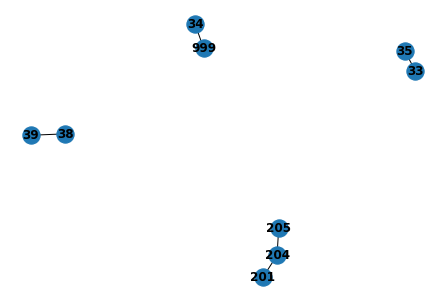

subgraphs: 4
examining this subgraph:
[('205', '204'), ('201', '204')]
the largest subtour is not connected to the road! Adding constraint!
205
[(205, 204), (205, 201), (205, 206)]
201
[(201, 204), (201, 200), (201, 205)]
204
[(204, 203), (204, 205), (204, 201)]
     constraint added:
<gurobi.LinExpr: 201_204_tour0_0_ + 201_204_tour0_1_ + 201_205_tour0_0_ + 201_205_tour0_1_ + 205_206_tour0_0_ + 205_206_tour0_1_ + 203_204_tour0_0_ + 203_204_tour0_1_ + 200_201_tour0_0_ + 200_201_tour0_1_ + 204_205_tour0_0_ + 204_205_tour0_1_>
4
     0     2   28.50000    0   12          -   28.50000      -     -    0s
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


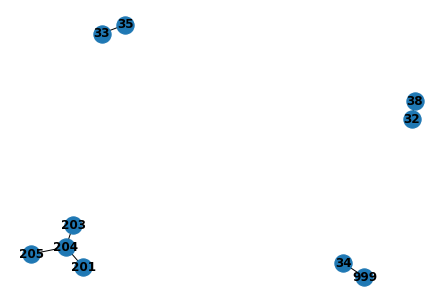

subgraphs: 4
examining this subgraph:
[('203', '204'), ('205', '204'), ('201', '204')]
the largest subtour is not connected to the road! Adding constraint!
203
[(203, 204), (203, 999)]
205
[(205, 204), (205, 201), (205, 206)]
201
[(201, 204), (201, 200), (201, 205)]
204
[(204, 203), (204, 205), (204, 201)]
     constraint added:
<gurobi.LinExpr: 201_204_tour0_0_ + 201_204_tour0_1_ + 201_205_tour0_0_ + 201_205_tour0_1_ + 205_206_tour0_0_ + 205_206_tour0_1_ + 203_204_tour0_0_ + 203_204_tour0_1_ + 200_201_tour0_0_ + 200_201_tour0_1_ + 203_999_tour0_0_ + 203_999_tour0_1_ + 204_205_tour0_0_ + 204_205_tour0_1_>
6
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


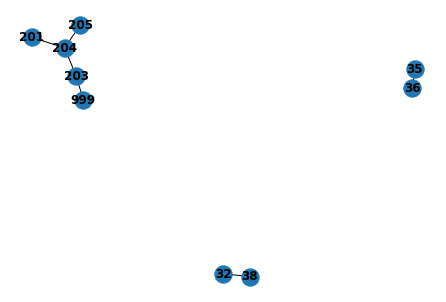

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201')]
The biggest component is already connected to parking.
tour1


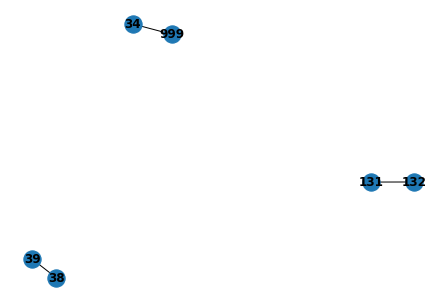

subgraphs: 3
examining this subgraph:
[('34', '999')]
The biggest component is already connected to parking.
tour2


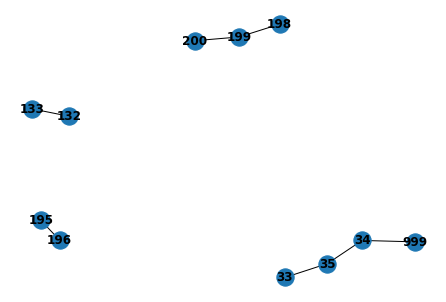

subgraphs: 4
examining this subgraph:
[('33', '35'), ('34', '35'), ('34', '999')]
The biggest component is already connected to parking.
!!!phase 1 is complete!!!
every tour now has an established largest component
now focus on removing unneeded subtours
H    6     6                      44.7000000   31.80000  28.9%   4.8    0s
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


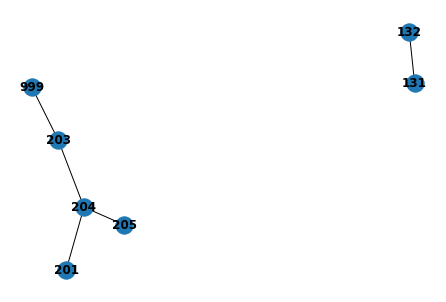

subgraphs: 2
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('131', '132')]
ok now what should I do about this subtour?
['131', '132']
biggest tour is between 201 and 205
this tour is between 131 and 132
this subtour is south of the biggest one132 less than 201
This subtour is too far away. We should exclude it.
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


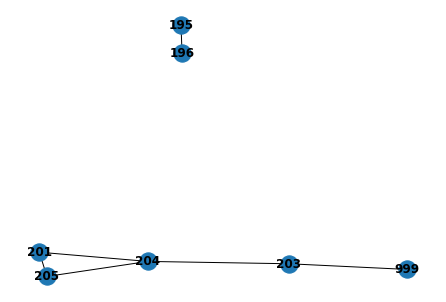

subgraphs: 2
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201'), ('205', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


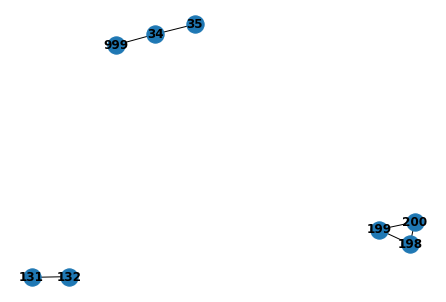

subgraphs: 3
examining this subgraph:
[('34', '35'), ('34', '999')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199'), ('198', '200'), ('199', '200')]
ok now what should I do about this subtour?
['198', '199', '200']
biggest tour is between 34 and 35
this tour is between 198 and 200
this subtour is north of the biggest one
This subtour is too far away. We should exclude it.
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


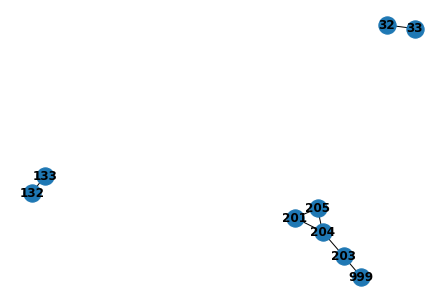

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201'), ('205', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('32', '33')]
ok now what should I do about this subtour?
['32', '33']
biggest tour is between 201 and 205
this tour is between 32 and 33
this subtour is south of the biggest one33 less than 201
This subtour is too far away. We should exclude it.
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


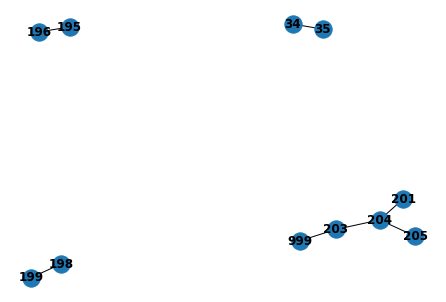

subgraphs: 4
examining this subgraph:
[('204', '203'), ('204', '205'), ('204', '201'), ('203', '999')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('34', '35')]
ok now what should I do about this subtour?
['34', '35']
biggest tour is between 201 and 205
this tour is between 34 and 35
this subtour is south of the biggest one35 less than 201
This subtour is too far away. We should exclude it.
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


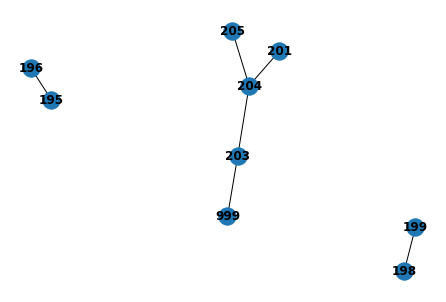

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199')]
ok now what should I do about this subtour?
['198', '199']
biggest tour is between 201 and 205
this tour is between 198 and 199
this subtour is south of the biggest one199 less than 201
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


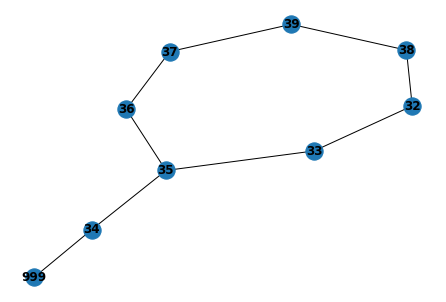

subgraphs: 1
this tour is already connected. moving to the next one
tour2


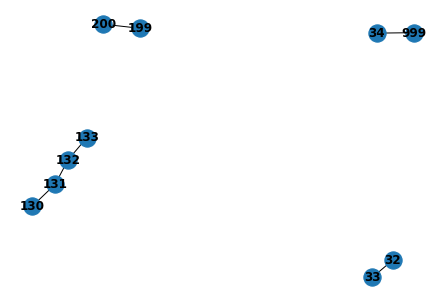

subgraphs: 4
examining this subgraph:
[('131', '132'), ('131', '130'), ('133', '132')]
the largest subtour is not connected to the road! Adding constraint!
131
[(131, 132), (131, 130), (131, 999)]
130
[(130, 129), (130, 133), (130, 131), (130, 999)]
133
[(133, 132), (133, 130), (133, 136)]
132
[(132, 131), (132, 133)]
     constraint added:
<gurobi.LinExpr: 132_133_tour2_0_ + 132_133_tour2_1_ + 129_130_tour2_0_ + 129_130_tour2_1_ + 130_133_tour2_0_ + 130_133_tour2_1_ + 133_136_tour2_0_ + 133_136_tour2_1_ + 131_132_tour2_0_ + 131_132_tour2_1_ + 130_999_tour2_0_ + 130_999_tour2_1_ + 130_131_tour2_0_ + 130_131_tour2_1_ + 131_999_tour2_0_ + 131_999_tour2_1_>
6
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


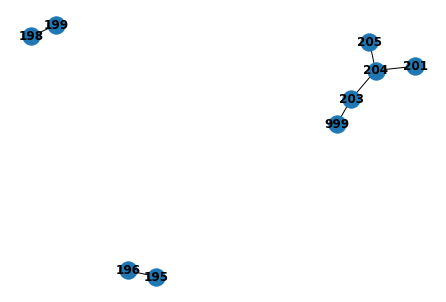

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199')]
ok now what should I do about this subtour?
['198', '199']
biggest tour is between 201 and 205
this tour is between 198 and 199
this subtour is south of the biggest one199 less than 201
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


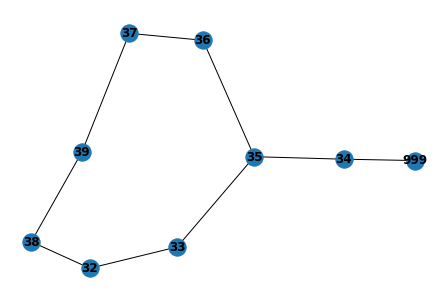

subgraphs: 1
this tour is already connected. moving to the next one
tour2


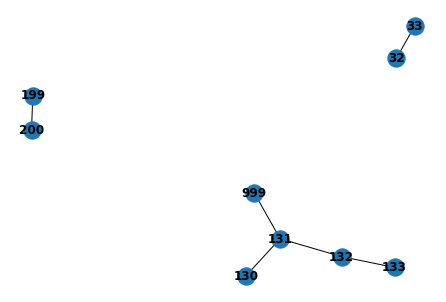

subgraphs: 3
examining this subgraph:
[('131', '132'), ('131', '130'), ('131', '999'), ('132', '133')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('32', '33')]
ok now what should I do about this subtour?
['32', '33']
biggest tour is between 130 and 133
this tour is between 32 and 33
this subtour is south of the biggest one33 less than 130
This subtour is too far away. We should exclude it.
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


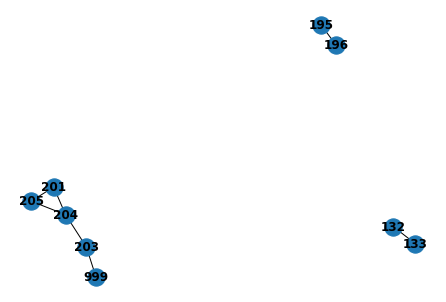

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201'), ('205', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('133', '132')]
ok now what should I do about this subtour?
['133', '132']
biggest tour is between 201 and 205
this tour is between 132 and 133
this subtour is south of the biggest one133 less than 201
This subtour is too far away. We should exclude it.
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


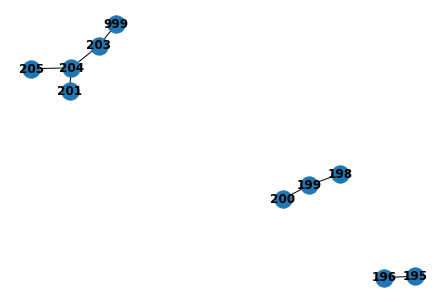

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199'), ('199', '200')]
ok now what should I do about this subtour?
['198', '199', '200']
biggest tour is between 201 and 205
this tour is between 198 and 200
this subtour is south of the biggest one200 less than 201
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


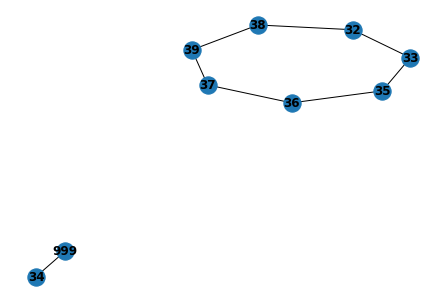

subgraphs: 2
examining this subgraph:
[('35', '36'), ('35', '33'), ('36', '37'), ('33', '32'), ('37', '39'), ('32', '38'), ('38', '39')]
the largest subtour is not connected to the road! Adding constraint!
35
[(35, 36), (35, 34), (35, 33)]
36
[(36, 35), (36, 33), (36, 37)]
33
[(33, 35), (33, 32), (33, 36)]
37
[(37, 36), (37, 39)]
32
[(32, 38), (32, 30), (32, 33)]
38
[(38, 32), (38, 39), (38, 999)]
39
[(39, 38), (39, 37), (39, 41)]
     constraint added:
<gurobi.LinExpr: 35_36_tour1_0_ + 35_36_tour1_1_ + 34_35_tour1_0_ + 34_35_tour1_1_ + 33_35_tour1_0_ + 33_35_tour1_1_ + 33_36_tour1_0_ + 33_36_tour1_1_ + 36_37_tour1_0_ + 36_37_tour1_1_ + 32_33_tour1_0_ + 32_33_tour1_1_ + 32_38_tour1_0_ + 32_38_tour1_1_ + 30_32_tour1_0_ + 30_32_tour1_1_ + 38_39_tour1_0_ + 38_39_tour1_1_ + 38_999_tour1_0_ + 38_999_tour1_1_ + 37_39_tour1_0_ + 37_39_tour1_1_ + 39_41_tour1_0_ + 39_41_tour1_1_>
7
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


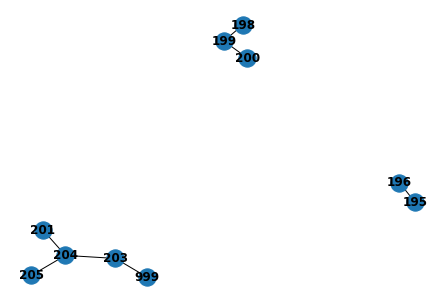

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199'), ('199', '200')]
ok now what should I do about this subtour?
['198', '199', '200']
biggest tour is between 201 and 205
this tour is between 198 and 200
this subtour is south of the biggest one200 less than 201
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


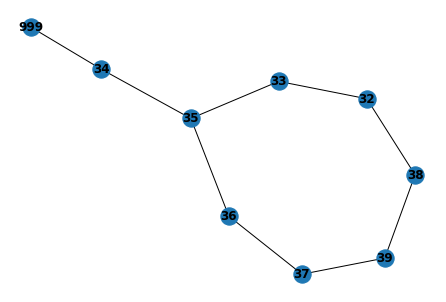

subgraphs: 1
this tour is already connected. moving to the next one
tour2


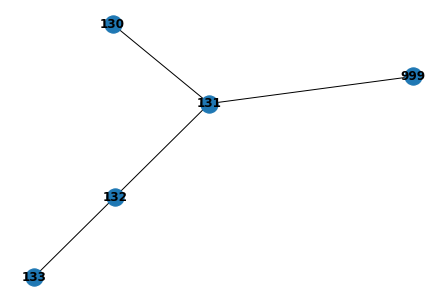

subgraphs: 1
this tour is already connected. moving to the next one
*  700   201              16      44.1000000   35.60000  19.3%   4.3    3s
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


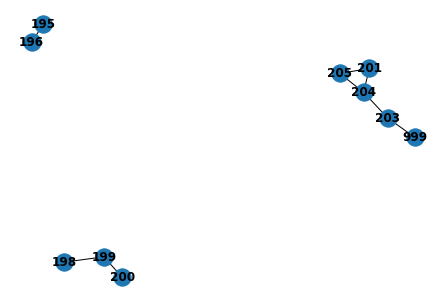

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201'), ('205', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199'), ('199', '200')]
ok now what should I do about this subtour?
['198', '199', '200']
biggest tour is between 201 and 205
this tour is between 198 and 200
this subtour is south of the biggest one200 less than 201
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


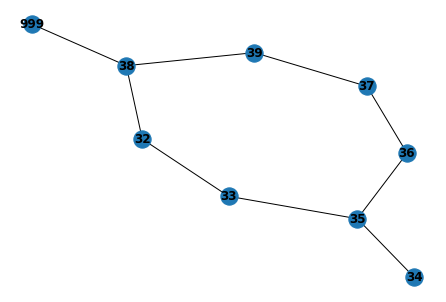

subgraphs: 1
this tour is already connected. moving to the next one
tour2


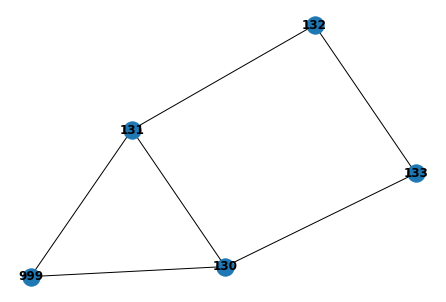

subgraphs: 1
this tour is already connected. moving to the next one
H  773   151                      41.8000000   36.50000  12.7%   4.4    3s
!!!!!!!!!!!!
ENTERING CALLBACK FUNCTION
!!!!!!!!!!!!
tour0


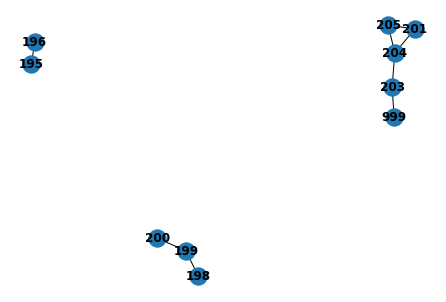

subgraphs: 3
examining this subgraph:
[('203', '204'), ('203', '999'), ('204', '205'), ('204', '201'), ('205', '201')]
The biggest component is already connected to parking.
this is the second phase, so continuing to the other components.
examining this subgraph:
[('198', '199'), ('199', '200')]
ok now what should I do about this subtour?
['198', '199', '200']
biggest tour is between 201 and 205
this tour is between 198 and 200
this subtour is south of the biggest one200 less than 201
examining this subgraph:
[('195', '196')]
ok now what should I do about this subtour?
['195', '196']
biggest tour is between 201 and 205
this tour is between 195 and 196
this subtour is south of the biggest one196 less than 201
tour1


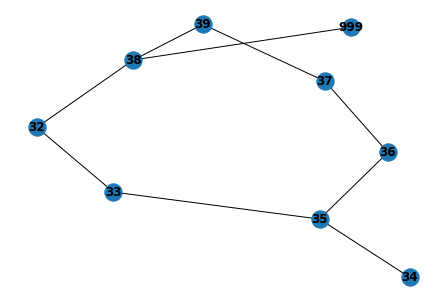

subgraphs: 1
this tour is already connected. moving to the next one
tour2


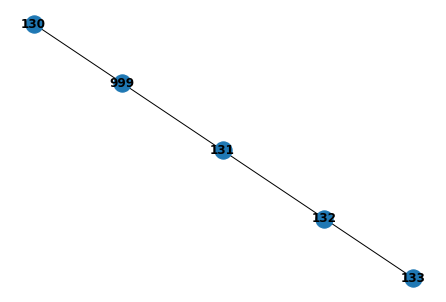

subgraphs: 1
this tour is already connected. moving to the next one
H  800   115                      41.0000000   37.20000  9.27%   4.6    4s

Cutting planes:
  Gomory: 11
  Cover: 4
  Implied bound: 54
  MIR: 11
  Inf proof: 2
  Lazy constraints: 10

Explored 954 nodes (4881 simplex iterations) in 4.21 seconds
Thread count was 1 (of 8 available processors)

Solution count 4: 41 41.8 44.1 44.7 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.100000000000e+01, best bound 4.100000000000e+01, gap 0.0000%


In [49]:
#do the thing
m.reset() #already ran for 36 hours
m.params.lazyConstraints = 1
m.params.threads = 1
m.Params.timeLimit = 24*60*60 #this ran for a day the first time and still wasn't finished when i cancelled it. 
                        #So for now i'm putting a really short timelimit and returning the best answer that
                        #   it can find in that time
                        #so that I can make sure that the solutions it's coming up with are at least correct

subtourEliminationPhase = 1
    
m.Params.LogFile = "log_24Hours.log"
m.optimize(subtourelim)
#m.optimize()

In [13]:
#print the results, sorted by variable name
vList = m.getVars()
vList.sort(key=lambda var: int(var.varName[:var.varName.find("_",0)]) if var.varName.find("_",0) > 0 else 1000 )


for v in vList:
    if(v.varName.find("_tour0_") != -1): 
        #if((v.varName.find("203") != -1) or (v.varName.find("204") != -1) or (v.varName.find("205") != -1)): #there's way too many variables, so for now only focusing on tour 0
            if(v.x > 0): 
                print('%s %g' % (v.varName, v.x))


195_196_tour0_0_ 1
195_196_tour0_1_ 1
201_204_tour0_0_ 1
201_205_tour0_0_ 1
203_204_tour0_0_ 1
203_204_tour0_1_ 1
203_999_tour0_0_ 1
203_999_tour0_1_ 1
204_205_tour0_0_ 1


In [32]:
constraints = m.getConstrs()


print(constraints)

[<gurobi.Constr R0>, <gurobi.Constr R1>, <gurobi.Constr R2>, <gurobi.Constr R3>, <gurobi.Constr R4>, <gurobi.Constr R5>, <gurobi.Constr R6>, <gurobi.Constr R7>, <gurobi.Constr R8>, <gurobi.Constr R9>, <gurobi.Constr R10>, <gurobi.Constr R11>, <gurobi.Constr R12>, <gurobi.Constr R13>, <gurobi.Constr R14>, <gurobi.Constr R15>, <gurobi.Constr R16>, <gurobi.Constr R17>, <gurobi.Constr R18>, <gurobi.Constr R19>, <gurobi.Constr R20>, <gurobi.Constr R21>, <gurobi.Constr R22>, <gurobi.Constr R23>, <gurobi.Constr R24>, <gurobi.Constr R25>, <gurobi.Constr R26>, <gurobi.Constr R27>, <gurobi.Constr R28>, <gurobi.Constr R29>, <gurobi.Constr R30>, <gurobi.Constr R31>, <gurobi.Constr R32>, <gurobi.Constr R33>, <gurobi.Constr R34>, <gurobi.Constr R35>, <gurobi.Constr R36>, <gurobi.Constr R37>, <gurobi.Constr R38>, <gurobi.Constr R39>, <gurobi.Constr R40>, <gurobi.Constr R41>, <gurobi.Constr R42>, <gurobi.Constr R43>, <gurobi.Constr R44>, <gurobi.Constr R45>, <gurobi.Constr R46>, <gurobi.Constr R47>, <